
Перевірка теореми Купманса (базис: cc-pvtz)
Атом       IE(ΔSCF)       -εHOMO      Різниця   %ΔSCF→HOMO       Exp.    %ΔSCF→Exp    %HOMO→Exp
--------------------------------------------------------------------------------------------------------------
He          23.4625      24.9699       1.5073         6.42        nan          nan          nan
Li           5.3422       5.3430       0.0008         0.02       5.39         0.89         0.87
Be           8.0447       8.4152       0.3706         4.61       9.32        13.68         9.71
B            8.0379       8.6542       0.6163         7.67       8.30         3.16         4.27
C           10.7981      11.9107       1.1126        10.30      11.26         4.10         5.78
N           13.8917      15.4746       1.5829        11.39      14.53         4.39         6.50
O           12.0106      16.5185       4.5079        37.53      13.62        11.82        21.28
F           15.6539      19.7808       4.1269        26.36      17.42       

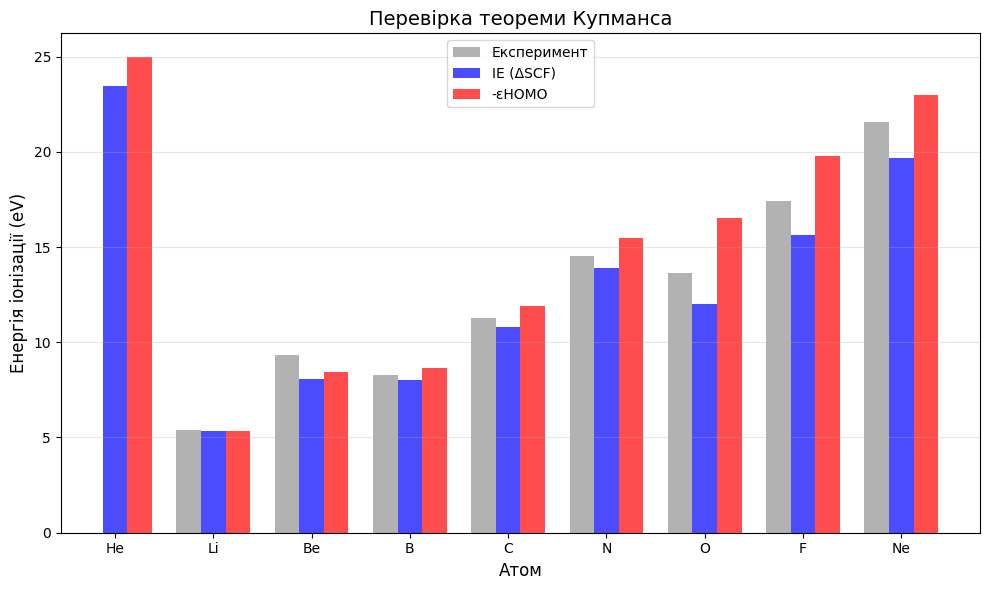

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from pyscf import gto, scf


def test_koopmans_theorem(atoms_list, basis="cc-pvtz"):
    """
    Перевірка теореми Купманса:
    порівняння ΔSCF, -εHOMO та експериментальних іонізаційних енергій.
    """

    # Експериментальні значення (eV)
    exp_ie = {
        "Li": 5.39,
        "Be": 9.32,
        "B": 8.30,
        "C": 11.26,
        "N": 14.53,
        "O": 13.62,
        "F": 17.42,
        "Ne": 21.56,
    }

    print(f"\nПеревірка теореми Купманса (базис: {basis})")
    print("=" * 110)
    print(
        f"{'Атом':6s} {'IE(ΔSCF)':>12s} {'-εHOMO':>12s} {'Різниця':>12s} "
        f"{'%ΔSCF→HOMO':>12s} {'Exp.':>10s} {'%ΔSCF→Exp':>12s} {'%HOMO→Exp':>12s}"
    )
    print("-" * 110)

    results = {
        "atoms": [],
        "ie_scf": [],
        "ie_koop": [],
        "ie_exp": [],
        "diff_scf_koop": [],
        "diff_scf_exp": [],
        "diff_koop_exp": [],
    }

    for symbol, spin_n, spin_c in atoms_list:
        # Нейтральний атом
        mol = gto.M(atom=f"{symbol} 0 0 0", basis=basis, spin=spin_n, verbose=0)
        mf = scf.UHF(mol) if spin_n != 0 else scf.RHF(mol)
        mf.conv_tol = 1e-11
        e_neutral = mf.kernel()

        # HOMO енергія
        if spin_n == 0:
            n_occ = mol.nelectron // 2
            eps_homo = mf.mo_energy[n_occ - 1]
        else:
            n_alpha = mol.nelec[0]
            eps_homo = mf.mo_energy[0][n_alpha - 1]

        ie_koopmans = -eps_homo * 27.211386  # eV

        # Катион
        mol_cat = gto.M(atom=f"{symbol} 0 0 0", basis=basis, charge=1, spin=spin_c, verbose=0)
        mf_cat = scf.UHF(mol_cat) if spin_c != 0 else scf.RHF(mol_cat)
        mf_cat.conv_tol = 1e-11
        e_cation = mf_cat.kernel()

        ie_scf = (e_cation - e_neutral) * 27.211386  # eV

        # Порівняння
        diff_scf_koop = ie_koopmans - ie_scf
        diff_scf_koop_percent = abs(diff_scf_koop / ie_scf) * 100

        ie_exp = exp_ie.get(symbol, np.nan)
        diff_scf_exp_percent = abs((ie_scf - ie_exp) / ie_exp) * 100 if not np.isnan(ie_exp) else np.nan
        diff_koop_exp_percent = abs((ie_koopmans - ie_exp) / ie_exp) * 100 if not np.isnan(ie_exp) else np.nan

        print(
            f"{symbol:6s} {ie_scf:12.4f} {ie_koopmans:12.4f} {diff_scf_koop:12.4f} "
            f"{diff_scf_koop_percent:12.2f} {ie_exp:10.2f} "
            f"{diff_scf_exp_percent:12.2f} {diff_koop_exp_percent:12.2f}"
        )

        # Збереження
        results["atoms"].append(symbol)
        results["ie_scf"].append(ie_scf)
        results["ie_koop"].append(ie_koopmans)
        results["ie_exp"].append(ie_exp)
        results["diff_scf_koop"].append(diff_scf_koop)
        results["diff_scf_exp"].append(diff_scf_exp_percent)
        results["diff_koop_exp"].append(diff_koop_exp_percent)

    print("=" * 110)

    mean_diff = np.nanmean(np.abs(results["diff_scf_koop"]))
    mean_err_scf = np.nanmean(results["diff_scf_exp"])
    mean_err_koop = np.nanmean(results["diff_koop_exp"])

    print(f"\nСередня |ΔSCF - Koopmans| різниця: {mean_diff:.3f} eV")
    print(f"Середня похибка ΔSCF від експерименту: {mean_err_scf:.2f}%")
    print(f"Середня похибка -εHOMO від експерименту: {mean_err_koop:.2f}%")

    # --- Графік ---
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(results["atoms"]))
    width = 0.25

    ax.bar(x - width, results["ie_exp"], width, label="Експеримент", color="gray", alpha=0.6)
    ax.bar(x, results["ie_scf"], width, label="IE (ΔSCF)", color="blue", alpha=0.7)
    ax.bar(x + width, results["ie_koop"], width, label="-εHOMO", color="red", alpha=0.7)

    ax.set_xlabel("Атом", fontsize=12)
    ax.set_ylabel("Енергія іонізації (eV)", fontsize=12)
    ax.set_title("Перевірка теореми Купманса", fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(results["atoms"])
    ax.legend()
    ax.grid(True, alpha=0.3, axis="y")

    plt.tight_layout()
    plt.savefig("koopmans_theorem_test.pdf")
    plt.show()

    return results


# --- Тестування ---
atoms_test = [
    ("He", 0, 1),
    ("Li", 1, 0),
    ("Be", 0, 1),
    ("B", 1, 0),
    ("C", 2, 1),
    ("N", 3, 2),
    ("O", 2, 3),
    ("F", 1, 2),
    ("Ne", 0, 1),
]

results_koop = test_koopmans_theorem(atoms_test)
